<a href="https://www.kaggle.com/code/someshyguy/chess-predictor?scriptVersionId=233271814" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=fffd981bebd598717dc3ddad3fa6452953d7e7e5dd3f56711e57f19c36496e20
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import chess

# Load the dataset
dataset_path = "/kaggle/input/chess-dataset/lichess_processed_1000000_games_first_15_moves.pkl"
with open(dataset_path, 'rb') as f:
    data = pickle.load(f)

print(f"Dataset size: {len(data)} games")

# 1. Get all unique ECO codes from the dataset
eco_codes = set()  # Use a set to automatically handle duplicates

# Extract ECO codes from the dataset
for game in data:
    eco_codes.add(game['eco'])

# 2. Create a mapping from ECO codes to integers
eco_encoding = {eco: idx for idx, eco in enumerate(sorted(eco_codes), start=1)}

# Optional: Add a default value for unknown ECO codes (this part remains the same)
default_eco = -1  # Default value for unknown ECO codes

# Process a single game into a tensor format for CNN
def convert_game_to_tensor(game_data):
    """
    Convert a single game into a tensor format suitable for CNN processing.
    
    Returns:
    - feature_vector: tabular features
    - board_tensor: board representation tensor
    """
    # 1. Extract tabular features
    feature_vector = []
    
    # Material and positional features at move 15
    feature_vector.append(game_data['white_material'])
    feature_vector.append(game_data['black_material'])
    feature_vector.append(game_data['material_balance'])
    feature_vector.append(int(game_data['white_can_castle']))
    feature_vector.append(int(game_data['black_can_castle']))
    feature_vector.append(game_data['white_center_control'])
    feature_vector.append(game_data['black_center_control'])
    
    # Legal moves count
    legal_moves = game_data['legal_moves_count'][:15]
    legal_moves = legal_moves + [0] * (15 - len(legal_moves))
    feature_vector.extend(legal_moves)
    
    # 2. Add ECO code to feature vector (integer encoding)
    eco_code = eco_encoding.get(game_data['eco'], default_eco)
    feature_vector.append(eco_code)
    
    # 3. Process actual moves (encoding the moves)
    # Creating a simple mapping for the moves
    move_encoding = {}  # Create or load a mapping for moves (you can use a one-hot encoding scheme or index-based encoding)
    move_index = []
    
    for move in game_data['moves'][:15]:  # Consider only the first 15 moves
        if move not in move_encoding:
            move_encoding[move] = len(move_encoding)  # Assign an index if not already present
        move_index.append(move_encoding[move])
    
    # Pad if there are fewer than 15 moves
    move_index = move_index + [0] * (15 - len(move_index))
    feature_vector.extend(move_index)
    
    # 4. Create a simple board representation
    # Instead of trying to recreate full board states, we'll use a simplified representation
    board_sequence = []
    
    # Get the lengths we need
    num_moves = min(15, len(game_data['legal_moves_count']) // 2)
    
    for i in range(num_moves):
        # Feature vector for this position
        position_features = []
        
        # Material and position features from the current state
        progress_ratio = (i + 1) / 15
        
        start_material = 39  # 8 pawns + 2 knights + 2 bishops + 2 rooks + 1 queen = 39
        white_material = int(start_material * (1 - progress_ratio) + game_data['white_material'] * progress_ratio)
        black_material = int(start_material * (1 - progress_ratio) + game_data['black_material'] * progress_ratio)
        material_balance = white_material - black_material
        
        position_features.append(white_material)
        position_features.append(black_material)
        position_features.append(material_balance)
        
        # Legal moves at this position (if available)
        move_idx = i * 2  # Each full move is 2 half-moves
        if move_idx < len(game_data['legal_moves_count']):
            position_features.append(game_data['legal_moves_count'][move_idx])
        else:
            position_features.append(0)
            
        if move_idx + 1 < len(game_data['legal_moves_count']):
            position_features.append(game_data['legal_moves_count'][move_idx + 1])
        else:
            position_features.append(0)
        
        # Add position index as a feature
        position_features.append(i)
        
        board_sequence.append(position_features)
    
    # Pad if we have fewer than 15 positions
    while len(board_sequence) < 15:
        # Padding with zeros
        board_sequence.append([0] * len(board_sequence[0]) if board_sequence else [0] * 6)
    
    return np.array(feature_vector, dtype=np.float32), np.array(board_sequence, dtype=np.float32)

# Custom dataset class
class ChessSequenceDataset(Dataset):
    def __init__(self, games_data, result_map=None):
        self.games_data = games_data
        self.result_map = result_map or {'1-0': 0, '0-1': 1, '1/2-1/2': 2}
        
        # Process all games at initialization
        self.features = []
        self.sequences = []
        self.labels = []
        
        for game in tqdm(games_data, desc="Processing games"):
            try:
                # Convert game to tensor format
                feature_vector, board_sequence = convert_game_to_tensor(game)
                
                self.features.append(feature_vector)
                self.sequences.append(board_sequence)
                self.labels.append(game['result_class'])
            except Exception as e:
                print(f"Error processing game: {e}")
                continue
        
        # Convert to numpy arrays
        self.features = np.array(self.features, dtype=np.float32)
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        print(f"Processed {len(self.labels)} games")
        print(f"Features shape: {self.features.shape}")
        print(f"Sequences shape: {self.sequences.shape}")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.sequences[idx], self.labels[idx]


# Create the dataset
print("Creating dataset...")
dataset = ChessSequenceDataset(data)

# Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset size: 976124 games
Creating dataset...


Processing games: 100%|██████████| 976124/976124 [00:27<00:00, 35744.93it/s]


Processed 976124 games
Features shape: (976124, 38)
Sequences shape: (976124, 15, 6)


Using device: cuda
Starting training...


Epoch 1/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 233.02it/s]


Epoch 1/50, Loss: 1.0614, Accuracy: 0.4863
  Class 0 accuracy: 0.2983 (28997/97199)
  Class 1 accuracy: 0.7076 (64096/90579)
  Class 2 accuracy: 0.2484 (1850/7447)
  New best accuracy: 0.4863 - Model saved


Epoch 2/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.14it/s]


Epoch 2/50, Loss: 1.0561, Accuracy: 0.3295
  Class 0 accuracy: 0.3414 (33182/97199)
  Class 1 accuracy: 0.2923 (26474/90579)
  Class 2 accuracy: 0.6268 (4668/7447)


Epoch 3/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.43it/s]


Epoch 3/50, Loss: 1.0557, Accuracy: 0.4325
  Class 0 accuracy: 0.4097 (39824/97199)
  Class 1 accuracy: 0.4583 (41512/90579)
  Class 2 accuracy: 0.4173 (3108/7447)


Epoch 4/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 233.63it/s]


Epoch 4/50, Loss: 1.0554, Accuracy: 0.5080
  Class 0 accuracy: 0.7072 (68741/97199)
  Class 1 accuracy: 0.3194 (28929/90579)
  Class 2 accuracy: 0.2029 (1511/7447)
  New best accuracy: 0.5080 - Model saved


Epoch 5/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.93it/s]


Epoch 5/50, Loss: 1.0553, Accuracy: 0.4823
  Class 0 accuracy: 0.4266 (41463/97199)
  Class 1 accuracy: 0.5575 (50494/90579)
  Class 2 accuracy: 0.2957 (2202/7447)


Epoch 6/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.04it/s]


Epoch 6/50, Loss: 1.0547, Accuracy: 0.4570
  Class 0 accuracy: 0.3451 (33543/97199)
  Class 1 accuracy: 0.5858 (53057/90579)
  Class 2 accuracy: 0.3528 (2627/7447)


Epoch 7/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.70it/s]


Epoch 7/50, Loss: 1.0544, Accuracy: 0.4777
  Class 0 accuracy: 0.2629 (25551/97199)
  Class 1 accuracy: 0.7249 (65658/90579)
  Class 2 accuracy: 0.2743 (2043/7447)


Epoch 8/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.59it/s]


Epoch 8/50, Loss: 1.0543, Accuracy: 0.4375
  Class 0 accuracy: 0.2792 (27140/97199)
  Class 1 accuracy: 0.6117 (55408/90579)
  Class 2 accuracy: 0.3851 (2868/7447)


Epoch 9/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.90it/s]


Epoch 9/50, Loss: 1.0544, Accuracy: 0.4122
  Class 0 accuracy: 0.3247 (31563/97199)
  Class 1 accuracy: 0.5026 (45521/90579)
  Class 2 accuracy: 0.4562 (3397/7447)


Epoch 10/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 238.18it/s]


Epoch 10/50, Loss: 1.0543, Accuracy: 0.4618
  Class 0 accuracy: 0.5685 (55253/97199)
  Class 1 accuracy: 0.3566 (32300/90579)
  Class 2 accuracy: 0.3502 (2608/7447)


Epoch 11/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 234.95it/s]


Epoch 11/50, Loss: 1.0545, Accuracy: 0.4627
  Class 0 accuracy: 0.4723 (45905/97199)
  Class 1 accuracy: 0.4613 (41786/90579)
  Class 2 accuracy: 0.3552 (2645/7447)


Epoch 12/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.49it/s]


Epoch 12/50, Loss: 1.0542, Accuracy: 0.5164
  Class 0 accuracy: 0.2797 (27191/97199)
  Class 1 accuracy: 0.8033 (72765/90579)
  Class 2 accuracy: 0.1164 (867/7447)
  New best accuracy: 0.5164 - Model saved


Epoch 13/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.55it/s]


Epoch 13/50, Loss: 1.0545, Accuracy: 0.4210
  Class 0 accuracy: 0.3291 (31985/97199)
  Class 1 accuracy: 0.5185 (46963/90579)
  Class 2 accuracy: 0.4353 (3242/7447)


Epoch 14/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.51it/s]


Epoch 14/50, Loss: 1.0542, Accuracy: 0.4907
  Class 0 accuracy: 0.4479 (43536/97199)
  Class 1 accuracy: 0.5542 (50197/90579)
  Class 2 accuracy: 0.2780 (2070/7447)


Epoch 15/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.04it/s]


Epoch 15/50, Loss: 1.0547, Accuracy: 0.4943
  Class 0 accuracy: 0.5731 (55703/97199)
  Class 1 accuracy: 0.4278 (38753/90579)
  Class 2 accuracy: 0.2754 (2051/7447)


Epoch 16/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.06it/s]


Epoch 16/50, Loss: 1.0542, Accuracy: 0.4317
  Class 0 accuracy: 0.4149 (40330/97199)
  Class 1 accuracy: 0.4503 (40792/90579)
  Class 2 accuracy: 0.4249 (3164/7447)


Epoch 17/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.10it/s]


Epoch 17/50, Loss: 1.0545, Accuracy: 0.4727
  Class 0 accuracy: 0.4616 (44866/97199)
  Class 1 accuracy: 0.4968 (45004/90579)
  Class 2 accuracy: 0.3240 (2413/7447)


Epoch 18/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 234.82it/s]


Epoch 18/50, Loss: 1.0545, Accuracy: 0.4739
  Class 0 accuracy: 0.3592 (34916/97199)
  Class 1 accuracy: 0.6102 (55269/90579)
  Class 2 accuracy: 0.3119 (2323/7447)


Epoch 19/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.56it/s]


Epoch 19/50, Loss: 1.0549, Accuracy: 0.4677
  Class 0 accuracy: 0.5239 (50925/97199)
  Class 1 accuracy: 0.4177 (37837/90579)
  Class 2 accuracy: 0.3427 (2552/7447)


Epoch 20/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.12it/s]


Epoch 20/50, Loss: 1.0541, Accuracy: 0.4932
  Class 0 accuracy: 0.6183 (60100/97199)
  Class 1 accuracy: 0.3771 (34158/90579)
  Class 2 accuracy: 0.2715 (2022/7447)


Epoch 21/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 238.31it/s]


Epoch 21/50, Loss: 1.0543, Accuracy: 0.4465
  Class 0 accuracy: 0.3746 (36411/97199)
  Class 1 accuracy: 0.5289 (47908/90579)
  Class 2 accuracy: 0.3828 (2851/7447)


Epoch 22/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.80it/s]


Epoch 22/50, Loss: 1.0544, Accuracy: 0.4576
  Class 0 accuracy: 0.5127 (49833/97199)
  Class 1 accuracy: 0.4063 (36798/90579)
  Class 2 accuracy: 0.3634 (2706/7447)


Epoch 23/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.51it/s]


Epoch 23/50, Loss: 1.0544, Accuracy: 0.4168
  Class 0 accuracy: 0.3990 (38780/97199)
  Class 1 accuracy: 0.4330 (39225/90579)
  Class 2 accuracy: 0.4528 (3372/7447)


Epoch 24/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.93it/s]


Epoch 24/50, Loss: 1.0542, Accuracy: 0.4462
  Class 0 accuracy: 0.4290 (41698/97199)
  Class 1 accuracy: 0.4691 (42490/90579)
  Class 2 accuracy: 0.3926 (2924/7447)


Epoch 25/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.71it/s]


Epoch 25/50, Loss: 1.0547, Accuracy: 0.5002
  Class 0 accuracy: 0.3211 (31208/97199)
  Class 1 accuracy: 0.7154 (64798/90579)
  Class 2 accuracy: 0.2222 (1655/7447)


Epoch 26/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 238.21it/s]


Epoch 26/50, Loss: 1.0542, Accuracy: 0.4264
  Class 0 accuracy: 0.4727 (45950/97199)
  Class 1 accuracy: 0.3762 (34080/90579)
  Class 2 accuracy: 0.4323 (3219/7447)


Epoch 27/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.22it/s]


Epoch 27/50, Loss: 1.0543, Accuracy: 0.4544
  Class 0 accuracy: 0.4955 (48160/97199)
  Class 1 accuracy: 0.4168 (37753/90579)
  Class 2 accuracy: 0.3751 (2793/7447)


Epoch 28/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.44it/s]


Epoch 28/50, Loss: 1.0545, Accuracy: 0.4910
  Class 0 accuracy: 0.3972 (38609/97199)
  Class 1 accuracy: 0.6099 (55242/90579)
  Class 2 accuracy: 0.2687 (2001/7447)


Epoch 29/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.15it/s]


Epoch 29/50, Loss: 1.0539, Accuracy: 0.4461
  Class 0 accuracy: 0.2898 (28173/97199)
  Class 1 accuracy: 0.6201 (56171/90579)
  Class 2 accuracy: 0.3679 (2740/7447)


Epoch 30/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.70it/s]


Epoch 30/50, Loss: 1.0541, Accuracy: 0.4724
  Class 0 accuracy: 0.4551 (44236/97199)
  Class 1 accuracy: 0.5035 (45609/90579)
  Class 2 accuracy: 0.3199 (2382/7447)


Epoch 31/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.55it/s]


Epoch 31/50, Loss: 1.0542, Accuracy: 0.4604
  Class 0 accuracy: 0.4469 (43434/97199)
  Class 1 accuracy: 0.4839 (43835/90579)
  Class 2 accuracy: 0.3518 (2620/7447)


Epoch 32/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.13it/s]


Epoch 32/50, Loss: 1.0542, Accuracy: 0.5119
  Class 0 accuracy: 0.5741 (55802/97199)
  Class 1 accuracy: 0.4689 (42477/90579)
  Class 2 accuracy: 0.2212 (1647/7447)


Epoch 33/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.43it/s]


Epoch 33/50, Loss: 1.0542, Accuracy: 0.4626
  Class 0 accuracy: 0.5225 (50787/97199)
  Class 1 accuracy: 0.4074 (36905/90579)
  Class 2 accuracy: 0.3521 (2622/7447)


Epoch 34/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.69it/s]


Epoch 34/50, Loss: 1.0538, Accuracy: 0.4457
  Class 0 accuracy: 0.3057 (29715/97199)
  Class 1 accuracy: 0.6018 (54510/90579)
  Class 2 accuracy: 0.3737 (2783/7447)


Epoch 35/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.44it/s]


Epoch 35/50, Loss: 1.0539, Accuracy: 0.4106
  Class 0 accuracy: 0.3717 (36128/97199)
  Class 1 accuracy: 0.4475 (40538/90579)
  Class 2 accuracy: 0.4685 (3489/7447)


Epoch 36/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.65it/s]


Epoch 36/50, Loss: 1.0541, Accuracy: 0.4461
  Class 0 accuracy: 0.4608 (44791/97199)
  Class 1 accuracy: 0.4355 (39444/90579)
  Class 2 accuracy: 0.3846 (2864/7447)


Epoch 37/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.35it/s]


Epoch 37/50, Loss: 1.0546, Accuracy: 0.4649
  Class 0 accuracy: 0.4917 (47797/97199)
  Class 1 accuracy: 0.4463 (40426/90579)
  Class 2 accuracy: 0.3401 (2533/7447)


Epoch 38/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.52it/s]


Epoch 38/50, Loss: 1.0537, Accuracy: 0.5060
  Class 0 accuracy: 0.5946 (57796/97199)
  Class 1 accuracy: 0.4339 (39304/90579)
  Class 2 accuracy: 0.2273 (1693/7447)


Epoch 39/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.16it/s]


Epoch 39/50, Loss: 1.0540, Accuracy: 0.5036
  Class 0 accuracy: 0.5203 (50577/97199)
  Class 1 accuracy: 0.5068 (45902/90579)
  Class 2 accuracy: 0.2460 (1832/7447)


Epoch 40/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.44it/s]


Epoch 40/50, Loss: 1.0541, Accuracy: 0.5180
  Class 0 accuracy: 0.7806 (75877/97199)
  Class 1 accuracy: 0.2649 (23996/90579)
  Class 2 accuracy: 0.1672 (1245/7447)
  New best accuracy: 0.5180 - Model saved


Epoch 41/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.45it/s]


Epoch 41/50, Loss: 1.0541, Accuracy: 0.4653
  Class 0 accuracy: 0.5946 (57798/97199)
  Class 1 accuracy: 0.3369 (30512/90579)
  Class 2 accuracy: 0.3391 (2525/7447)


Epoch 42/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.07it/s]


Epoch 42/50, Loss: 1.0540, Accuracy: 0.4726
  Class 0 accuracy: 0.5900 (57347/97199)
  Class 1 accuracy: 0.3586 (32480/90579)
  Class 2 accuracy: 0.3271 (2436/7447)


Epoch 43/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.70it/s]


Epoch 43/50, Loss: 1.0542, Accuracy: 0.4574
  Class 0 accuracy: 0.4199 (40812/97199)
  Class 1 accuracy: 0.5055 (45791/90579)
  Class 2 accuracy: 0.3612 (2690/7447)


Epoch 44/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.16it/s]


Epoch 44/50, Loss: 1.0541, Accuracy: 0.4458
  Class 0 accuracy: 0.5042 (49003/97199)
  Class 1 accuracy: 0.3874 (35090/90579)
  Class 2 accuracy: 0.3944 (2937/7447)


Epoch 45/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.77it/s]


Epoch 45/50, Loss: 1.0542, Accuracy: 0.4930
  Class 0 accuracy: 0.7528 (73173/97199)
  Class 1 accuracy: 0.2346 (21247/90579)
  Class 2 accuracy: 0.2449 (1824/7447)


Epoch 46/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 235.63it/s]


Epoch 46/50, Loss: 1.0543, Accuracy: 0.4860
  Class 0 accuracy: 0.5205 (50593/97199)
  Class 1 accuracy: 0.4648 (42100/90579)
  Class 2 accuracy: 0.2926 (2179/7447)


Epoch 47/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 237.35it/s]


Epoch 47/50, Loss: 1.0544, Accuracy: 0.4708
  Class 0 accuracy: 0.5454 (53012/97199)
  Class 1 accuracy: 0.4018 (36391/90579)
  Class 2 accuracy: 0.3358 (2501/7447)


Epoch 48/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.00it/s]


Epoch 48/50, Loss: 1.0538, Accuracy: 0.3924
  Class 0 accuracy: 0.3245 (31537/97199)
  Class 1 accuracy: 0.4561 (41309/90579)
  Class 2 accuracy: 0.5062 (3770/7447)


Epoch 49/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.46it/s]


Epoch 49/50, Loss: 1.0544, Accuracy: 0.4345
  Class 0 accuracy: 0.2550 (24781/97199)
  Class 1 accuracy: 0.6303 (57095/90579)
  Class 2 accuracy: 0.3949 (2941/7447)


Epoch 50/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 236.94it/s]


Epoch 50/50, Loss: 1.0542, Accuracy: 0.4501
  Class 0 accuracy: 0.4146 (40295/97199)
  Class 1 accuracy: 0.4940 (44746/90579)
  Class 2 accuracy: 0.3804 (2833/7447)


/tmp/ipykernel_19/291370274.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading best model...
Loaded best model from epoch 39 with accuracy: 0.5180
Performing detailed evaluation...


Evaluating: 100%|██████████| 1526/1526 [00:06<00:00, 249.50it/s]


Classification Report:
              precision    recall  f1-score   support

   White Win       0.55      0.78      0.64     97199
   Black Win       0.63      0.26      0.37     90579
        Draw       0.07      0.17      0.10      7447

    accuracy                           0.52    195225
   macro avg       0.41      0.40      0.37    195225
weighted avg       0.57      0.52      0.50    195225

Analysis complete!


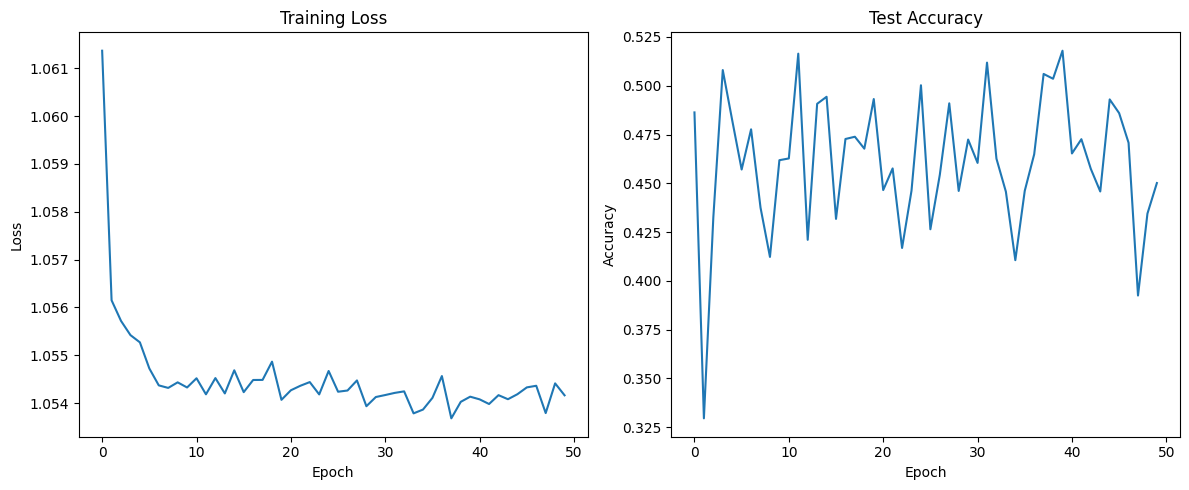

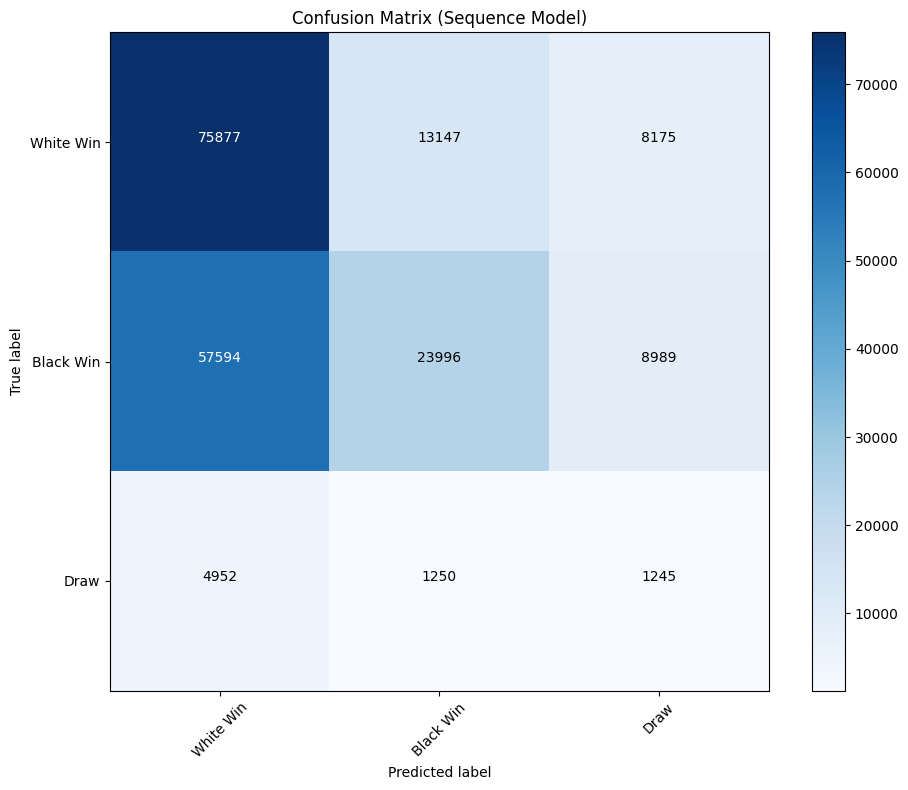

In [3]:
# Define the combined CNN-RNN model
class ChessSequenceModel(nn.Module):
    def __init__(self, tabular_size, seq_feature_size):
        super().__init__()
        
        # Add more dropout and batch normalization
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  # Add an extra dropout layer
        )
        
        # Consider using bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=seq_feature_size,
            hidden_size=128,
            num_layers=2,  # Increase layers
            batch_first=True,
            bidirectional=True,  # Capture patterns in both directions
            dropout=0.3
        )
        
        # Adjust combined size for bidirectional LSTM
        combined_size = 64 + (128 * 2)  # Bidirectional doubles hidden size
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )
    
    def forward(self, tabular, sequence):
        tabular_features = self.tabular_net(tabular)
        
        # Handle bidirectional LSTM
        lstm_out, (h_n, c_n) = self.lstm(sequence)
        
        # Concatenate forward and backward last hidden states
        lstm_features = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        combined = torch.cat((tabular_features, lstm_features), dim=1)
        output = self.classifier(combined)
        
        return output

# Initialize model
tabular_size = dataset.features.shape[1]
seq_feature_size = dataset.sequences.shape[2]
model = ChessSequenceModel(tabular_size, seq_feature_size)

# Define training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate class weights
class_counts = np.bincount(dataset.labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights) * len(class_counts)
weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

# Move model to device
model.to(device)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for tabular, sequence, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(tabular, sequence)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * tabular.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        class_correct = [0, 0, 0]
        class_total = [0, 0, 0]
        
        with torch.no_grad():
            for tabular, sequence, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} Testing"):
                tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(tabular, sequence)
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Per-class accuracy
                for i in range(3):
                    class_mask = (labels == i)
                    class_correct[i] += ((predicted == labels) & class_mask).sum().item()
                    class_total[i] += class_mask.sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        # Print statistics
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
        for i in range(3):
            class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f"  Class {i} accuracy: {class_acc:.4f} ({class_correct[i]}/{class_total[i]})")
        
        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
            }, 'best_chess_sequence_model.pth')
            print(f"  New best accuracy: {best_accuracy:.4f} - Model saved")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('sequence_training_curves.png')
    
    return model, train_losses, test_accuracies

def load_best_model(model, path='best_chess_sequence_model.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with accuracy: {checkpoint['accuracy']:.4f}")
    return model

# Train the model
print("Starting training...")
model, train_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=50
)

print("Loading best model...")
model = load_best_model(model)

# Evaluate the model
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for tabular, sequence, labels in tqdm(test_loader, desc="Evaluating"):
            tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
            outputs = model(tabular, sequence)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Sequence Model)')
    plt.colorbar()
    
    classes = ['White Win', 'Black Win', 'Draw']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('sequence_confusion_matrix.png')
    
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)
    
    return cm, report

# Run evaluation
print("Performing detailed evaluation...")
cm, report = evaluate_model(model, test_loader)

print("Analysis complete!")